# Initial analysis of the stereofog dataset

In [1]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from general_imports import *
import matplotlib
from matplotlib import cm   # colormap for the rating of the fogginess
from utils_stereofog import variance_of_laplacian
from PIL import Image
from ssim import SSIM

import cv2

In [2]:
os.chdir("/Users/anton/Nextcloud/stereofog_project_UofU")

In [3]:
dataset_path = 'stereofog_images'

## Calculating the Variance of the Laplacian for all images in the dataset

In [30]:
variance_values = []
image_count = 0
subfolder = 'B'

for folder in [item for item in os.listdir(dataset_path) if item[0] != '.' and '.xlsx' not in item and '.md' not in item]:
    
    for image in [item for item in os.listdir(os.path.join(dataset_path, folder, subfolder)) if item[0] != '.']:

        image_count += 1
        image_path = os.path.join(dataset_path, folder, subfolder, image)
        image_gray = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
        variance_values.append(variance_of_laplacian(image_gray))

print('Total images: {}'.format(image_count))
print('Mean variance: {}'.format(sum(variance_values) / len(variance_values)))

Total images: 9838
Mean variance: 24.027115621904116


In [31]:
variance_values_df = pd.Series(sorted(variance_values))

## Treating the distribution with the Interguartile Rule

In [32]:
Q1 = np.percentile(variance_values_df, 25, method='midpoint')
Q3 = np.percentile(variance_values_df, 75, method='midpoint')
IQR = Q3 - Q1

upper=Q3+1.5*IQR
lower=Q1-1.5*IQR

In [36]:
print(f'Proportion of datapoints retained: {len(variance_values_df[(variance_values_df < upper) & (variance_values_df > lower)]) / len(variance_values_df)*100:.2f}%')

Proportion of datapoints retained: 85.94%


## Plotting the cropped distribution

/Users/anton/.pyenv/versions/3.9.7/envs/stereofog/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/anton/.pyenv/versions/3.9.7/envs/stereofog/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


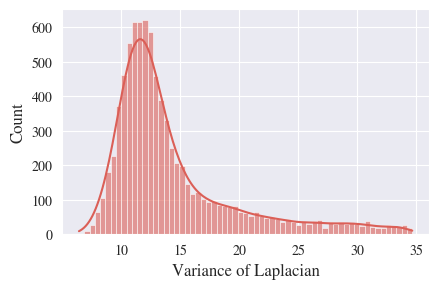

In [37]:
fig, ax = plt.subplots(figsize=set_size())

sns.histplot(variance_values_df[(variance_values_df < upper) & (variance_values_df > lower)], ax = ax, kde=True, fill=True, alpha=0.6)
ax.set_xlabel('Variance of Laplacian')
ax.set_ylabel('Count')

plt.savefig('stereofog/plots/stereofog_dataset_variances.pdf', format='pdf', bbox_inches='tight')

# ax.set_title(f'Variances of Laplacian for Stereofog Dataset ({len(variance_values_df[(variance_values_df < upper) & (variance_values_df > lower)]) / len(variance_values_df)*100:.2f}% of images)')
plt.show()

## Plotting example images for low, medium and high fog
### Horizontal plot

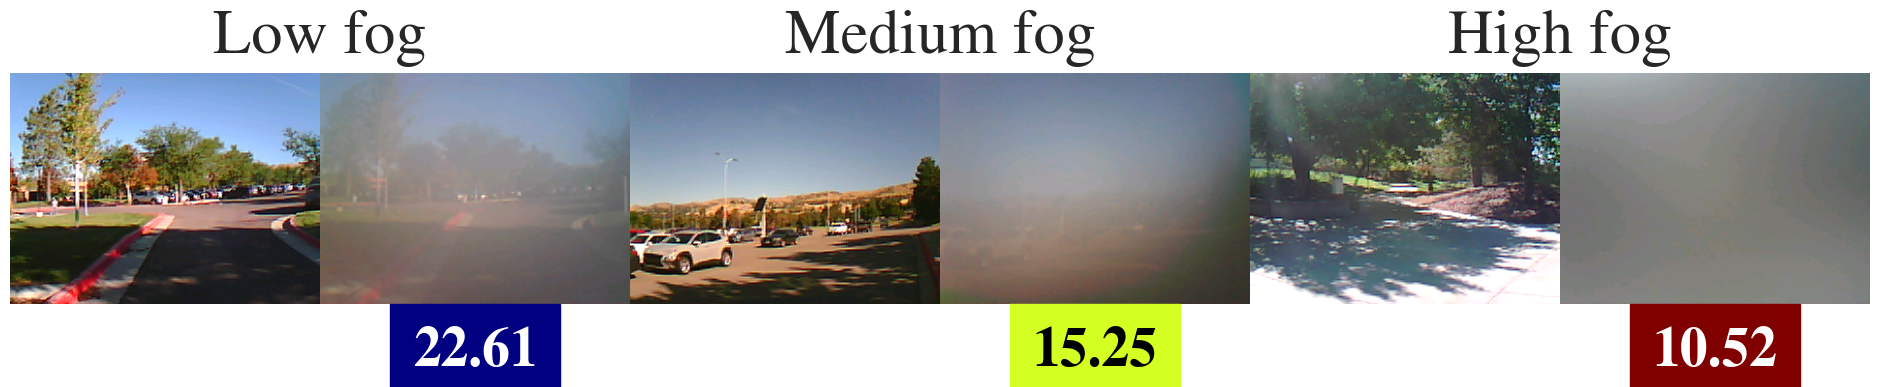

In [6]:
ratio = 4 / 3

width_per_image = 4
height_per_image = width_per_image / ratio

num_images = 6
fig = plt.figure(figsize=(num_images*width_per_image, height_per_image))

ax = [fig.add_subplot(1,num_images,i+1) for i in range(num_images)]

images =    [   '2023-08-17_RUN1__120.bmp', # low fog example
                '2023-08-11_RUN1__12.bmp', # medium fog example
                '2023-08-10_RUN1__2.bmp' # high fog example
            ]

dataset_path = 'stereofog_images'

variances = [] # list of variances of Laplacian for each image

for index, image in enumerate(images):

    parent_folder = image.replace('__', '/').split('/')[0]
    img_A_path = os.path.join(dataset_path, parent_folder, 'A', image)
    img_B_path = os.path.join(dataset_path, parent_folder, 'B', image)

    img_A = plt.imread(img_A_path)
    img_B = plt.imread(img_B_path)

    ax[index*2].imshow(img_A, aspect='auto')
    ax[index*2].axis('off')
    ax[index*2+1].imshow(img_B, aspect='auto')
    ax[index*2+1].axis('off')

    # ax[index*2].text(0.5, 0, image, horizontalalignment='center', verticalalignment='bottom', transform=ax[index*2].transAxes, fontsize=18, backgroundcolor='white')

    # Calculating the variance of Laplacian of the fogged image and adding it to the plot
    img_B_gray = cv2.cvtColor(img_B, cv2.COLOR_BGR2GRAY)
    variances += [variance_of_laplacian(img_B_gray)]
    
norm = matplotlib.colors.Normalize(vmin=min(variances), vmax=max(variances))    # Normalizer for the values of the colormap rating the fogginess of the image: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib


for index in range(num_images//2):
    ax[index*2+1].text(0.5, -0.099, f'{variances[index]:.2f}', horizontalalignment='center', verticalalignment='top', transform=ax[index*2+1].transAxes, fontweight='bold', backgroundcolor=cm.jet_r(norm(variances[index])), fontsize=40, color='black' if index == 1 else 'white')

ax[0].text(1., 1.15, 'Low fog', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=45)
ax[2].text(1., 1.15, 'Medium fog', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=45)
ax[4].text(1., 1.15, 'High fog', horizontalalignment='center', verticalalignment='center', transform=ax[4].transAxes, fontsize=45)

plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('stereofog/plots/stereofog_dataset_examples_horizontal.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Vertical plot

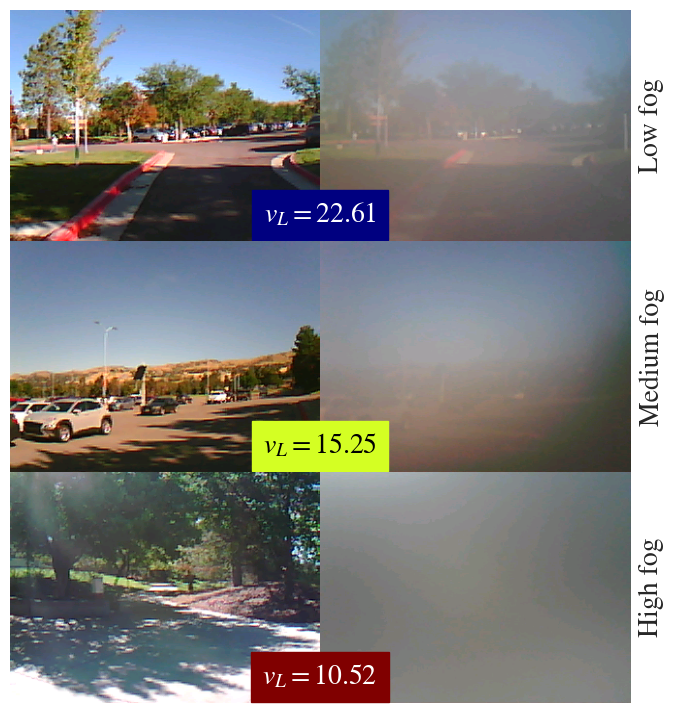

In [44]:
ratio = 4 / 3

width_per_image = 4
height_per_image = width_per_image / ratio

num_images = 6
# fig = plt.figure()

# ax = [fig.add_subplot(1,num_images,i+1) for i in range(num_images)]

fig, ax = plt.subplots((num_images//2), (num_images//3), figsize=((num_images/3)*width_per_image, (num_images/2)*height_per_image))

images =    [   '2023-08-17_RUN1__120.bmp', # low fog example
                '2023-08-11_RUN1__12.bmp', # medium fog example
                '2023-08-10_RUN1__2.bmp' # high fog example
            ]

dataset_path = 'stereofog_images'

variances = [] # list of variances of Laplacian for each image

for index, image in enumerate(images):

    parent_folder = image.replace('__', '/').split('/')[0]
    img_A_path = os.path.join(dataset_path, parent_folder, 'A', image)
    img_B_path = os.path.join(dataset_path, parent_folder, 'B', image)

    img_A = plt.imread(img_A_path)
    img_B = plt.imread(img_B_path)

    ax[index, 0].imshow(img_A, aspect='auto')
    ax[index, 0].axis('off')
    ax[index, 1].imshow(img_B, aspect='auto')
    ax[index, 1].axis('off')

    # Calculating the variance of Laplacian of the fogged image and adding it to the plot
    img_B_gray = cv2.cvtColor(img_B, cv2.COLOR_BGR2GRAY)
    variances += [variance_of_laplacian(img_B_gray)]
    
norm = matplotlib.colors.Normalize(vmin=min(variances), vmax=max(variances))    # Normalizer for the values of the colormap rating the fogginess of the image: https://stackoverflow.com/questions/25408393/getting-individual-colors-from-a-color-map-in-matplotlib


for index in range(num_images//2):
    ax[index, 1].text(0.0, 0.053, f'$v_L={variances[index]:.2f}$', horizontalalignment='center', verticalalignment='bottom', transform=ax[index, 1].transAxes, fontweight='bold', backgroundcolor=cm.jet_r(norm(variances[index])), fontsize=20, color='black' if index == 1 else 'white')

ax[0, 1].text(1.07, 0.5, 'Low fog', horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=ax[0, 1].transAxes, fontsize=20)
ax[1, 1].text(1.07, 0.5, 'Medium fog', horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=ax[1, 1].transAxes, fontsize=20)
ax[2, 1].text(1.07, 0.5, 'High fog', horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=ax[2, 1].transAxes, fontsize=20)

plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('stereofog/plots/stereofog_dataset_examples_vertical.pdf', format='pdf', bbox_inches='tight')
plt.savefig('stereofog/plots/stereofog_dataset_examples_vertical.png', format='png', bbox_inches='tight', dpi=500)
plt.show()

# Synthetic Dataset evaluation

## Plotting example dataset images

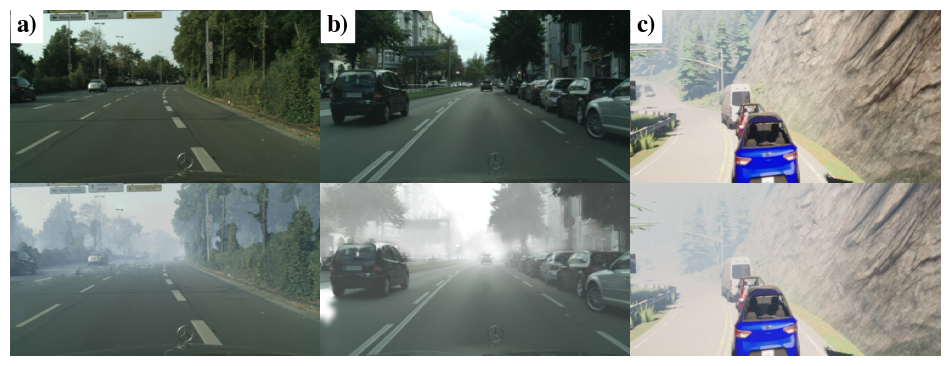

In [11]:
results_path = 'stereofog/results/synthetic_datasets'

subfolder = 'test_latest/images'

datasets = [item for item in os.listdir(results_path) if item[0] != '.' and 'old' not in item]

ratio = 16 / 9

width_per_image = 4
height_per_image = width_per_image / ratio

num_images = 2 * len(datasets)
fig, ax = plt.subplots(2, len(datasets), figsize=(len(datasets)*width_per_image, 2*height_per_image))

# counter = 1
# ax = []
# for i in range(2):
#     for j in range(len(datasets)):
#         # print(counter)
#         ax += [fig.add_subplot(2, len(datasets), counter)]
#         counter += 1

# images = {'carla_tuebingen_pix2pix': 'rural_00000224_density_0_05_real_B.png',
#           'cityscapes_tuebingen_pix2pix': 'munster_000158_000019_leftImg8bit_real_B.png',
#           'foggy_cityscapes_pix2pix': 'berlin_000002_000019_leftImg8bit_real_B.png'
#          }

images = {'carla_tuebingen_pix2pix': 'Rural_Fog_density_0.05~V300_00000214_real_B.png',
          'cityscapes_tuebingen_pix2pix': 'munster_000170_000019_leftImg8bit_V150_real_B.png',
          'foggy_cityscapes_pix2pix': 'berlin_000006_000019_leftImg8bit_foggy_beta_0.02_real_B.png'
         }

titles = {  'carla_tuebingen_pix2pix': 'c)',#'CARLA Uni Tübingen',
            'cityscapes_tuebingen_pix2pix': 'a)',#'Cityscapes Uni Tübingen',
            'foggy_cityscapes_pix2pix': 'b)'#'Foggy Cityscapes'
            }

for index, dataset in enumerate(datasets):
    image = images[dataset]#sorted([item for item in os.listdir(os.path.join(results_path, dataset, subfolder)) if 'real_B' in item])[0]

    ax[0, index].imshow(plt.imread(os.path.join(results_path, dataset, subfolder, image)), aspect='auto')
    ax[0, index].axis('off')

    ax[0, index].text(0.02, 0.97, titles[dataset], horizontalalignment='left', verticalalignment='top', transform=ax[0, index].transAxes, fontweight='bold', fontsize=18, color='black', backgroundcolor='white')

    ax[1, index].imshow(plt.imread(os.path.join(results_path, dataset, subfolder, image.replace('real_B', 'real_A'))), aspect='auto')
    ax[1, index].axis('off')

plt.subplots_adjust(hspace=0, wspace=0)

# plt.savefig('plots/synthetic_datasets_examples.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Plotting pix2pix results on synthetic dataset

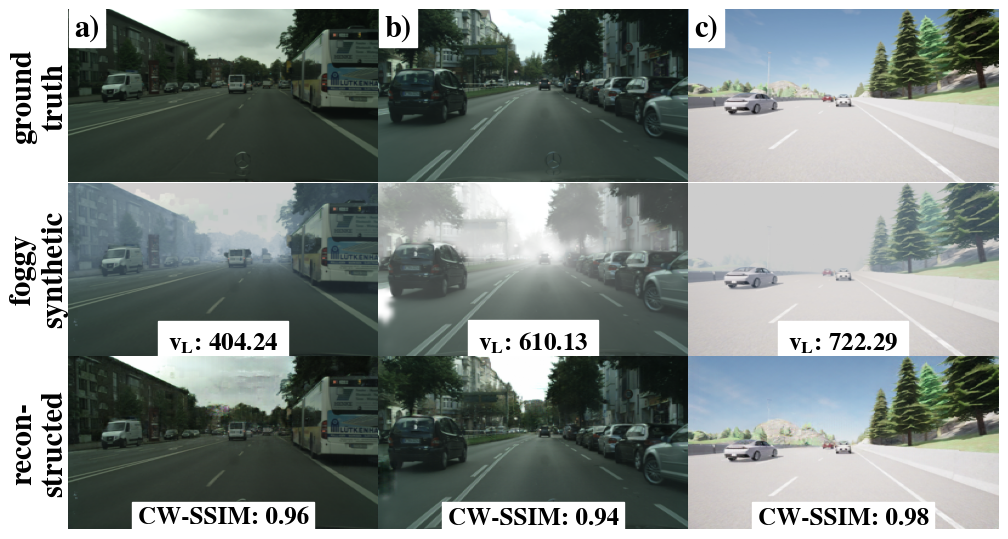

In [7]:
results_path = 'stereofog/results/synthetic_datasets'

subfolder = 'test_latest/images'

datasets = [item for item in os.listdir(results_path) if item[0] != '.' and 'old' not in item]

ratio = 16 / 9

width_per_image = 4
height_per_image = width_per_image / ratio

num_images = 3*len(datasets)
fig, ax = plt.subplots(3, len(datasets), figsize=(len(datasets)*width_per_image, 3*height_per_image))

# counter = 1
# ax = []
# for i in range(2):
#     for j in range(len(datasets)):
#         # print(counter)
#         ax += [fig.add_subplot(2, len(datasets), counter)]
#         counter += 1

images = {'carla_tuebingen_pix2pix': 'Motorway_density_0.02_00000083_real_B.png',
          'cityscapes_tuebingen_pix2pix': 'munster_000128_000019_leftImg8bit_V300_real_B.png',
          'foggy_cityscapes_pix2pix': 'berlin_000006_000019_leftImg8bit_foggy_beta_0.02_real_B.png'
         }
         
# images = {'carla_tuebingen_pix2pix': 'motorway_00000084_density_0_02_real_B.png',
#           'cityscapes_tuebingen_pix2pix': 'munster_000163_000019_leftImg8bit_real_B.png',
#           'foggy_cityscapes_pix2pix': 'berlin_000006_000019_leftImg8bit_real_B.png'
#          }

titles = {  'carla_tuebingen_pix2pix': 'c)',#'CARLA Uni Tübingen',
            'cityscapes_tuebingen_pix2pix': 'a)',#'Cityscapes Uni Tübingen',
            'foggy_cityscapes_pix2pix': 'b)'#'Foggy Cityscapes'
            }

for index, dataset in enumerate(datasets):
    image = images[dataset]#sorted([item for item in os.listdir(os.path.join(results_path, dataset, subfolder)) if 'real_B' in item])[0]

    ax[0, index].imshow(plt.imread(os.path.join(results_path, dataset, subfolder, image)), aspect='auto')
    ax[0, index].axis('off')

    ax[0, index].text(0.02, 0.97, titles[dataset], horizontalalignment='left', verticalalignment='top', transform=ax[0, index].transAxes, fontweight='bold', fontsize=22, color='black', backgroundcolor='white')

    ax[1, index].imshow(plt.imread(os.path.join(results_path, dataset, subfolder, image.replace('real_B', 'real_A'))), aspect='auto')
    ax[1, index].axis('off')

    ax[2, index].imshow(plt.imread(os.path.join(results_path, dataset, subfolder, image.replace('real_B', 'fake_B'))), aspect='auto')
    ax[2, index].axis('off')

    # Calculating the CW-SSIM between real and fake images
    CW_SSIM = SSIM(Image.open(os.path.join(results_path, dataset, subfolder, image))).cw_ssim_value(Image.open(os.path.join(results_path, dataset, subfolder, image.replace('real_B', 'fake_B'))))

    ax[2, index].text(0.5, 0., f'CW-SSIM: {CW_SSIM:.2f}', horizontalalignment='center', verticalalignment='bottom', transform=ax[2, index].transAxes, fontweight='bold', fontsize=18, backgroundcolor='white', color='black')

    fogged_image_gray = cv2.cvtColor(cv2.imread(os.path.join(results_path, dataset, subfolder, image)), cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(fogged_image_gray)
    # Putting the value of the variance of the Laplacian on the image
    ax[1, index].text(0.5,0., '$\mathbf{v_{L}}$: %.2f' %fm, transform=ax[1, index].transAxes, horizontalalignment='center', verticalalignment='bottom', fontweight='black', backgroundcolor='white', fontsize=18, color='black')
    

plt.subplots_adjust(hspace=0, wspace=0)

# Adding labels for clear, foggy and synthetic images
ax[0, 0].text(-0., 0.5, 'ground\ntruth', horizontalalignment='right', verticalalignment='center', ma='center', transform=ax[0, 0].transAxes, fontweight='bold', fontsize=22, color='black', rotation=90)
ax[1, 0].text(-0., 0.5, 'foggy\nsynthetic', horizontalalignment='right', verticalalignment='center', ma='center', transform=ax[1, 0].transAxes, fontweight='bold', fontsize=22, color='black', rotation=90)
ax[2, 0].text(-0., 0.5, 'recon-\nstructed', horizontalalignment='right', verticalalignment='center', ma='center', transform=ax[2, 0].transAxes, fontweight='bold', fontsize=22, color='black', rotation=90)

plt.savefig('stereofog/plots/synthetic_datasets_results.pdf', format='pdf', bbox_inches='tight')
plt.show()